In [1]:
import numpy as np
import math 
import bitarray
from math import *
from matplotlib import pyplot as plt

In [2]:
## shift : the amount on which the basis function is shifted by
## number : the number of the basis function start at 0
##number = t
T = 1 ##The lenght of the basis function
value = 1/math.sqrt(T) ## The height of the function considering it is a rect

f_s = 22050
T_s = 1/f_s
sigma = 0.05


#x the basis number
def basis(x,t):
    if x >T and x<=(1+T) : 
        return value
    
def r(t) :
    return sinc(t)

def basis_rect(t) :
    return 

In [3]:
B = 0.5
T = 2

def root_raised_cos(t):
    return 4*B / (pi*sqrt(T)) * (cos((1+B)*pi*t/T) + (1-B)*pi/(4*B)*np.sinc((1-B)*t/T))/ (1 - (4*B*t/T)**2)

In [4]:
print(root_raised_cos(-0.12498866213151927))

0.7962022183108991


In [5]:
##basis discrete
## vector of the basis function
def basis():
    func = np.vectorize(root_raised_cos)
    linspace = np.linspace(-2*T, 2*T, num = f_s)
    return func(linspace)

In [6]:
def root_raised_shifted():
    cos_discrete = np.cos(np.linspace(-2*T, 2*T, num = f_s))
    return np.convolve(basis(), cos_discrete)

In [7]:
def text_to_bit(text):
    ba = bitarray.bitarray()
    ba.frombytes(text.encode('utf-8'))
    ba = np.fromiter(map(lambda x : 1 if x else 0, ba.tolist()), dtype = int)
    return ba

In [8]:
def bit_to_text(bit):
    ba = bitarray.bitarray(bit.tolist())
    r = ba.tobytes()
    return  str(r,'utf8')

In [9]:
#right now convert (0,1) array to (-1 , 1) array
def b_to_c(array):
    c_s = (array -1/2)*2
    return c_s

In [10]:
##### Design a transmitter that reads a text file and returns real-valued samples of an
#information-bearing signal s[n].
#arg text_file : an array of sended values
const_size = 2
def transmitter(text_file):
    size = text_file.shape[0]
    result = np.zeros(size*f_s)
    for i in range(size):
        result[f_s*i:f_s*(i+1)] = text_file[i]*basis()
    return result

In [11]:
string_text = "Constantin"
constellation = b_to_c(text_to_bit(string_text))
a = transmitter(constellation)

In [12]:
training_sequence_start = np.cos(2*pi* 100* np.arange(1000)/f_s)
training_sequence_end = np.cos(2*pi*200*np.arange(1000)/f_s)

In [36]:
def fourier_transform(x, start, end):
    nb_coef = end - start
    result = np.zeros(nb_coef)
    n = np.arange(x.shape[0])
    for f in np.arange(start, end):
        result[f - start] = np.abs(np.sum(x/f_s * np.exp(-2*1j*pi* f * (n/f_s))))
    
    return result

In [14]:
a_training_sequence = np.concatenate((training_sequence_start, a, training_sequence_end), axis = 0)

N = a_training_sequence.shape[0]
n= np.arange(N)
f0 = 2000
a_training_sequence_shifted = (a_training_sequence*np.exp(1j *2 * pi * f0 * n/f_s)).real
transformed_start = a_training_sequence_shifted[:1000]
transformed_end = a_training_sequence_shifted[-1000:]

In [15]:
np.savetxt('input.txt', a_training_sequence_shifted)

In [20]:
!python3 client.py --input_file='input.txt' --output_file='output.txt' --srv_hostname=iscsrv72.epfl.ch --srv_port=80

In [21]:
array_2 = np.loadtxt('output.txt')

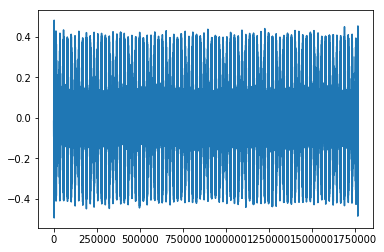

In [22]:
plt.plot(array_2)

In [23]:
convolution_start = np.convolve(array_2, np.flip(transformed_start), mode= 'same')
convolution_end = np.convolve(array_2, np.flip(transformed_end), mode = 'same')

In [24]:
norm_start = np.linalg.norm(transformed_start)
norm_end = np.linalg.norm(transformed_end)

In [25]:
convolved_norm_output = np.sqrt(np.convolve(array_2**2, np.ones(10000), mode = 'same'))

In [26]:
start = np.argmax(convolution_start - norm_start*convolved_norm_output) + int(len(training_sequence_start)//2)
end = np.argmax(convolution_end - norm_end*convolved_norm_output) - int(len(training_sequence_end) //2)
array_2_processed = array_2[start-1000:end+1000] ##Just cancels the noisze but keep the training sequence

N_2 = array_2_processed.shape[0]
array_2_processed_reshifted = (array_2_processed * np.exp(1j * 2 * pi * f0 * np.arange(N_2)/f_s)).real

array_2_pre_decode = array_2_processed_reshifted[1000:-1000] ##We delete the traning sequence

In [27]:
print(start, end)

3076 1767076


In [30]:
print(array_2_pre_decode.shape == a.shape)

True


In [31]:
def decode(array_2) : 
    size = 22050
    result = np.zeros(len(constellation))
    b = basis()
    for i in range(len(constellation))  :
        result[i] = np.sum(basis()*array_2_pre_decode[size*i: size*(i+1)])
    return (np.sign(result)+1)/2

In [32]:
d = decode(array_2_pre_decode)
print(bit_to_text(d))

Constantin


In [45]:
print(constellation)

[-1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.
 -1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.
  1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1.
 -1.  1.  1. -1.  1.  1.  1. -1.]


In [46]:
def low_pass(arr, f_0):
    T = 2*f_0
    t = np.arange(-100,100)/f_s
    sinc = T *np.sinc(T*t)
    return np.convolve(arr, sinc, mode = 'same')

'sp = np.fft.fft(np.sinc(t))\nfreq = np.fft.fftfreq(t.shape[-1])\nplt.plot(freq, sp.real, freq, sp.imag)\nplt.show()'

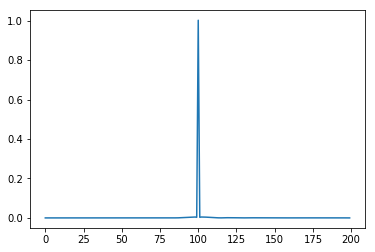

In [38]:
t = np.arange(-100000,100000)/f_s
a = np.sinc(t)
plt.plot(fourier_transform(a, -100, 100))
'''sp = np.fft.fft(np.sinc(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, sp.real, freq, sp.imag)
plt.show()'''

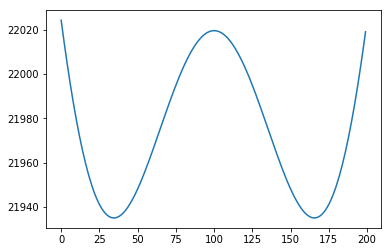

In [48]:
r = low_pass(np.sinc(t), 500)
plt.plot(fourier_transform(r, -100,100))

Do we have to do a discretization of a continuous signal to send this array ? When you apply the noise, do you reconstruct it or apply it on the discrete signal.

Do we us have to reconstruct a countinuous signal 


In [31]:
##### qam
def qam(array):
    pad_val = int(T//T_s)
    int_size = pad_val + f_s
    
    loop_size = len(array)//2
    
    result = np.zeros(loop_size*int_size)
    
    for i in range(loop_size) : 
        r1 = array[2*i]*basis()
        r1 =  np.pad(r1, (0,pad_val) ,'constant', constant_values = (0))
        #need to pad to add 0 at the begining
        
        r2  = array[2*i+1]*basis()
        r2 =  np.pad(r2, (pad_val,0) ,'constant', constant_values = (0))
        r = r1+r2
        result[i*int_size : (i+1)*int_size ] = r
        
    return result

In [33]:
a = [1,-1,1]
qam(a)

44099


array([ 0.03001054,  0.0300142 ,  0.03001784, ..., -0.03001784,
       -0.0300142 , -0.03001054])